In [1]:
from src.filehandler import DataHandler
from src.regressor import Regressor, r_square, rmse
from stop_words import get_stop_words
import src.utils as utils

Using TensorFlow backend.


### Análisis de datos

Para analizar los resultados obtenidos por la regresión vamos a calcular varias métricas, las que son:
* Silimarity search, busqueda de los más cercanos. Para los 5000 vectores de test se guardan
  las posiciones de los 1000 vectores más cercanos, de 1000 vectores, lo que se traduce en un
  ordenamiento de las predicciones segun distancia entre el descriptor de texto y el de imagen.
* Un vector de posiciones correctas, para cada descriptor de texto se calcula donde está ubicada
  la respuesta correcta dada la matriz obtenida en similarity search, serian 5000 números entre
  el 1 y el 1000. Con esto se muestra un histograma para visualizar mejor la frecuencia de las posiciones.
* Recall@k, que correspode al porcentaje de esos 5000 números que son menores o iguales a K.
  Especificamente se calcula recall@1, recall@5 y recall@10.
* MRR o mean reciprocal rank
* Posición promedio del vector de posiciones correctas.


## Crear descriptores de texto para los test propuestos

Primero cargamos los datos necesarios para calcular los descriptores de texto, para los 6 test
descritos más arriba.

In [2]:
stop_words = get_stop_words('spanish')
data_A = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
data_B = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_B_data")
data_C = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_C_data")
X_test1= data_A.get_data_test(method="count-vectorizer", stop_words=None, ngram_range=(1,1), verbose=False)
X_test2= data_A.get_data_test(method="count-vectorizer", stop_words=None, ngram_range=(1,4), verbose=False)
X_test3= data_A.get_data_test(method="count-vectorizer", stop_words=stop_words, ngram_range=(1,4), verbose=False)
X_test4= data_A.get_data_test(method="tf-idf", stop_words=None, ngram_range=(1,1), verbose=False)
X_test5= data_A.get_data_test(method="tf-idf", stop_words=None, ngram_range=(1,4), verbose=False)
X_test6= data_A.get_data_test(method="tf-idf", stop_words=stop_words, ngram_range=(1,4), verbose=False)

# Cargar modelos ya entrenados

In [19]:
reg1 = Regressor()
reg2 = Regressor()
reg3 = Regressor()
reg4 = Regressor()
reg5 = Regressor()
reg6 = Regressor()
reg1.load("cv_ngram11_none", custom_objects={"rmse": rmse, "r_square": r_square})
#metrics = reg1.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 1)")
reg2.load("cv_ngram14_none", custom_objects={"rmse": rmse, "r_square": r_square})
#metrics = reg2.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 4)")
reg3.load("cv_ngram14_stop_words", custom_objects={"rmse": rmse, "r_square": r_square})
#metrics = reg3.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 4), con stop_words")
reg4.load("tf_idf_ngram11_none", custom_objects={"rmse": rmse, "r_square": r_square})
#metrics = reg4.plot_metrics("metricas en TF-IDF, ngram-range=(1, 1)")
reg5.load("tf_idf_ngram14_none", custom_objects={"rmse": rmse, "r_square": r_square})
#metrics = reg5.plot_metrics("metricas en TF-IDF, ngram-range=(1, 4)")
reg6.load("tf_idf_ngram14_stop_words", custom_objects={"rmse": rmse, "r_square": r_square})
#metrics = reg6.plot_metrics("metricas en TF-IDF, ngram-range=(1, 4), con stop_words")

loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!
loading model from disk ... done!


{'val_loss': [0.5650842899084091,
  0.5327450925111771,
  0.5234263491630554,
  0.5188657006621361,
  0.5152706876397133,
  0.5133718013763428,
  0.5115069505572319,
  0.5101133632659912,
  0.5095411774516105,
  0.5087075477838516,
  0.5082444640994072,
  0.5077093371748924,
  0.5072874450683593,
  0.5068290036916733,
  0.5067006722092628,
  0.506496100127697,
  0.5061767566204071,
  0.5063279980421066,
  0.506118289232254,
  0.5061190876364708,
  0.5058612051606178],
 'val_mean_absolute_error': [0.45666539132595063,
  0.44752243340015413,
  0.44464411824941635,
  0.44640072613954546,
  0.43592496335506437,
  0.43497498661279677,
  0.4374319511651993,
  0.4366004964709282,
  0.4337594589591026,
  0.4371562367677689,
  0.43017113745212554,
  0.4311803212761879,
  0.4330332165956497,
  0.4345514303445816,
  0.4387482297420502,
  0.43252440214157106,
  0.4358582961559296,
  0.4310702058672905,
  0.43213445544242857,
  0.4374802678823471,
  0.43448262989521025],
 'val_rmse': [0.74009079933

# Calcular indicadores

Calculamos los vectores resultantes de evaluar los test en las regresiones, y se cargan tambien los descriptores de imagen de largo 1000, para hacer luego el similarity search.

In [6]:
#calculamos los vectores resultantes del predict para cada test
vectores_1 = reg1.predict(X_test1)
vectores_2 = reg2.predict(X_test2)
vectores_3 = reg3.predict(X_test3)
vectores_4 = reg4.predict(X_test4)
vectores_5 = reg5.predict(X_test5)
vectores_6 = reg6.predict(X_test6)
#cargamos los descriptores de imagenes
y_simple_test_A = data_A.load_simple_test("A") #este es el que usaremos a priori
#los test B y C se usaran para hacer una validacion final para ver si hay overfitting
y_simple_test_B = data_B.load_simple_test("B")
y_simple_test_C = data_C.load_simple_test("C")

leyendo ./data/test_A_data/test_A_images_names.txt
leyendo ./data/test_A_data/test_A_images_vectors.bin
1000 vectores de largo 2048
leyendo ./data/test_B_data/test_B_images_names.txt
leyendo ./data/test_B_data/test_B_images_vectors.bin
1000 vectores de largo 2048
leyendo ./data/test_C_data/test_C_images_names.txt
leyendo ./data/test_C_data/test_C_images_vectors.bin
1000 vectores de largo 2048


In [8]:
#cargar medidor de indicadores para Similarity search, recall at k, MRR y Mean
from src.indicators import Indicators
ind = Indicators()

In [9]:
rank_1 = ind.similarity_search(y_simple_test_A, vectores_1)
datos_1 = ind.get_formated_data()
rank_2 = ind.similarity_search(y_simple_test_A, vectores_2)
datos_2 = ind.get_formated_data()
rank_3 = ind.similarity_search(y_simple_test_A, vectores_3)
datos_3 = ind.get_formated_data()
rank_4 = ind.similarity_search(y_simple_test_A, vectores_4)
datos_4 = ind.get_formated_data()
rank_5 = ind.similarity_search(y_simple_test_A, vectores_5)
datos_5 = ind.get_formated_data()
rank_6 = ind.similarity_search(y_simple_test_A, vectores_6)
datos_6 = ind.get_formated_data()

initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1756 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3962 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 4892 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.9min finished


done! (elapse time: 176.81 secs.)
getting sorted ranking ...done! (elapse time: 0.05 secs.)
done!
initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1756 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3962 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4892 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  3.1min finished


done! (elapse time: 183.82 secs.)
getting sorted ranking ...done! (elapse time: 0.05 secs.)
done!
initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 1756 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3962 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4892 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  3.3min finished


done! (elapse time: 197.6 secs.)
getting sorted ranking ...done! (elapse time: 0.05 secs.)
done!
initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 1756 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3962 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4892 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  3.1min finished


done! (elapse time: 187.8 secs.)
getting sorted ranking ...done! (elapse time: 0.05 secs.)
done!
initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 1756 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3962 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4892 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  3.3min finished


done! (elapse time: 197.21 secs.)
getting sorted ranking ...done! (elapse time: 0.05 secs.)
done!
initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1756 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3962 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4892 tasks      | elapsed:  3.0min


done! (elapse time: 187.13 secs.)
getting sorted ranking ...done! (elapse time: 0.05 secs.)
done!


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  3.1min finished


# Mostrar datos obtenidos

Luego de calculados los vectores de posiciones, se grafican sus respectivos histogramas y una tabla con las metricas mencionadas anteriormente.

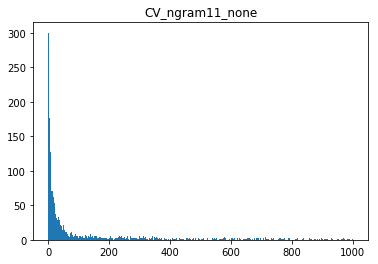

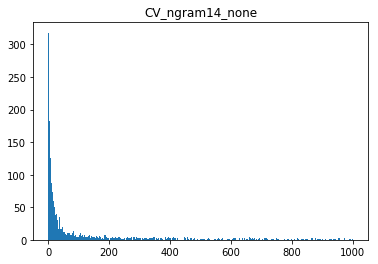

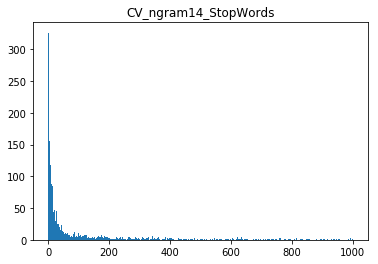

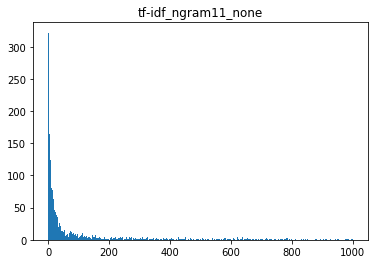

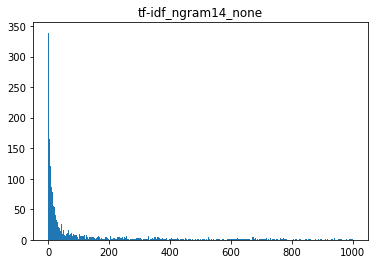

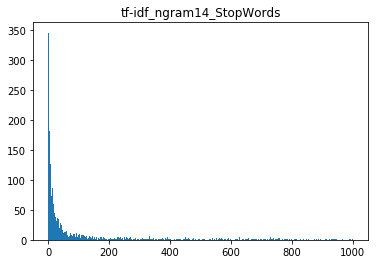

In [13]:
labels = ['recall@1','recall@5','recall@10','MRR','Mean']
index = ['CV_ngram11_none', 'CV_ngram14_none','CV_ngram14_StopWords',
         'tf-idf_ngram11_none', 'tf-idf_ngram14_none','tf-idf_ngram14_StopWords']
datos = [datos_1, datos_2, datos_3,datos_4, datos_5, datos_6]
tabla = utils.get_table(datos, index, labels)
utils.print_histo(rank_1,index[0])
utils.print_histo(rank_2,index[1])
utils.print_histo(rank_3,index[2])
utils.print_histo(rank_4,index[3])
utils.print_histo(rank_5,index[4])
utils.print_histo(rank_6,index[5])

In [14]:
tabla

,recall@1,recall@5,recall@10,MRR,Mean
CV_ngram11_none,0.0600,0.2192,0.3416,0.147287,123.0536
CV_ngram14_none,0.0636,0.2266,0.3402,0.150460,119.7922
CV_ngram14_StopWords,0.0652,0.2228,0.3458,0.152514,119.9920
tf-idf_ngram11_none,0.0644,0.2208,0.3376,0.149207,122.3536
tf-idf_ngram14_none,0.0678,0.2246,0.3464,0.153862,118.4948
tf-idf_ngram14_StopWords,0.0692,0.2248,0.3450,0.155181,119.1726


Se observa que todos los experimentos tienen metricas muy parecidas, pero el que tiene las mejores métricas en general es el TF-IDF con ngram_range = (1,4) y con stop_words de español. Entonces probaremos con los test B y C para ver si tienen metricas similares tambien.

In [15]:
X_test6_B= data_B.get_data_test(method="tf-idf", stop_words=stop_words, ngram_range=(1,4))
X_test6_C= data_C.get_data_test(method="tf-idf", stop_words=stop_words, ngram_range=(1,4))
vectores_6_B = reg6.predict(X_test6_B)
vectores_6_C = reg6.predict(X_test6_C)
rank_6_B = ind.similarity_search(y_simple_test_B, vectores_6_B)
datos_6_B = ind.get_formated_data()
rank_6_C = ind.similarity_search(y_simple_test_C, vectores_6_C)
datos_6_C = ind.get_formated_data()

leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_B_data//test_B_images_names.txt
leyendo ./data/test_B_data//test_B_images_vectors.bin
1000 vectores de largo 2048
doing vectorization with TfidfVectorizer
fitting ...done
getting test vectors transforms ...text descriptor shape: (5000, 640)
done
leyendo ./data/train_data/train_images_names.txt
leyendo ./data/train_data/train_images_vectors.bin
20000 vectores de largo 2048
leyendo ./data/test_C_data//test_C_images_names.txt
leyendo ./data/test_C_data//test_C_images_vectors.bin
1000 vectores de largo 2048
doing vectorization with TfidfVectorizer
fitting ...done
getting test vectors transforms ...text descriptor shape: (5000, 640)
done
initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 1756 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3962 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4892 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  3.3min finished


done! (elapse time: 199.31 secs.)
getting sorted ranking ...done! (elapse time: 0.05 secs.)
done!
initializing KDTRee ... done!
computing distances with L2 metric ...

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 1756 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2394 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3128 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3962 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4892 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  3.4min finished


done! (elapse time: 205.19 secs.)
getting sorted ranking ...done! (elapse time: 0.09 secs.)
done!


In [16]:
index = ['Test_A', 'Test_B','Test_C']
datos = [datos_6, datos_6_B, datos_6_C]
tabla = utils.get_table(datos, index, labels)
tabla

,recall@1,recall@5,recall@10,MRR,Mean
Test_A,0.0692,0.2248,0.3450,0.155181,119.1726
Test_B,0.0732,0.2348,0.3498,0.157697,120.7294
Test_C,0.0668,0.2364,0.3634,0.158091,108.4202


In [18]:
#prueba esto, debiera funcionar sin problemas
from joblib import Parallel, delayed
import multiprocessing
     
# what are your inputs, and what operation do you want to 
# perform on each input. For example...
inputs = range(10) 
def processInput(i):
    return i * i
 
num_cores = multiprocessing.cpu_count()
     
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
results

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]